In [1]:
# !pip install bertopic

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bertopic import BERTopic
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

import re

from wordcloud import WordCloud

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
posts_df = pd.read_csv('datasets/filtered_posts_df.csv')
posts_df.head()

post_text  \
0  Будет ли еще мой менторский курс по IT Рекрутм...   
1  08.08.22 - 1й день с командой IT_One.Долгождан...   
2  Как менторам развивать Data Science сообщество...   
3  Пора рассекретится! Начался новый период на бл...   
4  Завершился третий поток менторской программы д...   

                                  reacted_users_info  \
0  {'https://www.linkedin.com/in/ACoAABdk1nkBsBNQ...   
1  {'https://www.linkedin.com/in/ACoAADlYxTkBWDm_...   
2  {'https://www.linkedin.com/in/ACoAADe6becBwuAU...   
3  {'https://www.linkedin.com/in/ACoAAD7Ow-sBU2ef...   
4  {'https://www.linkedin.com/in/ACoAAD-ysXcBrnVM...   

                                          job_titles  
0  Senior DevOps, Python, Go, Terraform, AWS Seni...  
1  Employer brand Lead Lead System Administrator ...  
2  Machine Learning Researcher | Academic Leader ...  
3  Senior QA Automation Engineer at OZON.ru Lead ...  
4  Founder GradeBuilder | Lead QA – AstralSoft | ...

In [4]:
developer_df = pd.read_json('datasets/developer_profiles.json')
developer_df.head()

name    city connections  \
nurlan-isbulaev-34bb211a3   Nurlan Isbulaev  Moscow        500+   
maria-terenteva             Maria Terenteva  Moscow        500+   
руслан-гусейнов-091858186   Руслан Гусейнов  Russia        500+   
kirill-gonin                   Kirill Gonin  Russia         180   
alexey-sergienko           Alexey Sergienko  Moscow         168   

                                                      role  \
nurlan-isbulaev-34bb211a3                Backend Developer   
maria-terenteva               Frontend Developer | Angular   
руслан-гусейнов-091858186               Frontend Developer   
kirill-gonin               Full Stack Developer JavaScript   
alexey-sergienko                        Software Developer   

                                                     company  experience  \
nurlan-isbulaev-34bb211a3                          Доброзайм        3.92   
maria-terenteva                                  LLC "ROBIN"        3.67   
руслан-гусейнов-091858186                            OZON.ru        3.67   
kirill-gonin               «Сервисный центр Транстелематика»        2.75   
alexey-sergienko                                     OZON.ru        9.83   

                          employment_type  \
nurlan-isbulaev-34bb211a3       Full-time   
maria-terenteva                 Full-time   
руслан-гусейнов-091858186       Full-time   
kirill-gonin                    Full-time   
alexey-sergienko                Full-time   

                                                                      skills  \
nurlan-isbulaev-34bb211a3  [JSON, AutoCAD, PHP, Технология строительного ...   
maria-terenteva            [Git, HTML, Отчетность, Ведение переговоров, Д...   
руслан-гусейнов-091858186  [Vuex, WebSockets, ООП, git, TypeScript, Gulp,...   
kirill-gonin               [React, Jest, Material-UI, Express, CSS, HTML,...   
alexey-sergienko           [Электроника, Git, Vue.js, HTML, electron , Re...   

                                                                   reactions  \
nurlan-isbulaev-34bb211a3  [🔥 11 сервисов на базе ИИ ,которые помогут про...   
maria-terenteva            [Me being a parent:, Всем привет!Активно ищу р...   
руслан-гусейнов-091858186  [#humor #it, Я #нанимаю. Знаете людей, которых...   
kirill-gonin               [Вы обращали внимание как здорово и быстро раз...   
alexey-sergienko           [Why is PR one of the crucial areas to pay att...   

                                                                       posts  
nurlan-isbulaev-34bb211a3  [🔥 11 сервисов на базе ИИ ,которые помогут про...  
maria-terenteva            [None, None, None, None, None, None, None, Non...  
руслан-гусейнов-091858186  [None, None, None, None, None, None, None, Non...  
kirill-gonin               [Всем привет!Собеседование на английском языке...  
alexey-sergienko           [Я только что получил(а) значок за навык «Разр...

В данном случае у нас могут дублироваться многие посты(с реакциями) как внутри одного пользователя, так и между пользователями. Чтобы решить эту проблему, мы можем создать `set` из всех постов.

Для начала склеим списки

In [5]:
developer_df['all_posts'] = developer_df['reactions'] + developer_df['posts']
developer_df.head(3)

name    city connections  \
nurlan-isbulaev-34bb211a3  Nurlan Isbulaev  Moscow        500+   
maria-terenteva            Maria Terenteva  Moscow        500+   
руслан-гусейнов-091858186  Руслан Гусейнов  Russia        500+   

                                                   role      company  \
nurlan-isbulaev-34bb211a3             Backend Developer    Доброзайм   
maria-terenteva            Frontend Developer | Angular  LLC "ROBIN"   
руслан-гусейнов-091858186            Frontend Developer      OZON.ru   

                           experience employment_type  \
nurlan-isbulaev-34bb211a3        3.92       Full-time   
maria-terenteva                  3.67       Full-time   
руслан-гусейнов-091858186        3.67       Full-time   

                                                                      skills  \
nurlan-isbulaev-34bb211a3  [JSON, AutoCAD, PHP, Технология строительного ...   
maria-terenteva            [Git, HTML, Отчетность, Ведение переговоров, Д...   
руслан-гусейнов-091858186  [Vuex, WebSockets, ООП, git, TypeScript, Gulp,...   

                                                                   reactions  \
nurlan-isbulaev-34bb211a3  [🔥 11 сервисов на базе ИИ ,которые помогут про...   
maria-terenteva            [Me being a parent:, Всем привет!Активно ищу р...   
руслан-гусейнов-091858186  [#humor #it, Я #нанимаю. Знаете людей, которых...   

                                                                       posts  \
nurlan-isbulaev-34bb211a3  [🔥 11 сервисов на базе ИИ ,которые помогут про...   
maria-terenteva            [None, None, None, None, None, None, None, Non...   
руслан-гусейнов-091858186  [None, None, None, None, None, None, None, Non...   

                                                                   all_posts  
nurlan-isbulaev-34bb211a3  [🔥 11 сервисов на базе ИИ ,которые помогут про...  
maria-terenteva            [Me being a parent:, Всем привет!Активно ищу р...  
руслан-гусейнов-091858186  [#humor #it, Я #нанимаю. Знаете людей, которых...

Преобразуем все в лист и раскроем списки рекурсией. Функция ниже раскроет список любой вложенности

In [6]:
def flatten_list(nested_list):
    flattened_list = []
    for item in nested_list:
        if isinstance(item, list):
            flattened_list.extend(flatten_list(item))
        else:
            flattened_list.append(item)
    return flattened_list

In [7]:
user_posts_list = flatten_list(developer_df['all_posts'].tolist())
len(user_posts_list)

11600

Все верно, 290 * 40 = 11600. Теперь обернем это в set и посмотрим на уникальные посты

In [8]:
user_posts_set = set(user_posts_list)
len(user_posts_set)

1617

In [9]:
user_posts_set

{'If you often feel desperate, it might mean your resilience and "embracing the unknown" skills are remarkable or about to become great.There are a ton of articles and blog posts about how it is essential to be resilient. Many of them draw an excellent high-level picture and break down what resilience is into smaller buckets. But I\'ve not seen many that explained the things you go through exactly each time you hit the wall. At the same time, I\'ve noticed that on the path of empowering resilience, many of my peers — including myself — almost always went through one crucial step, yet barely talked about and brought up to the public or themselves. And recognizing this step could help you bounce back faster whenever you fall.I\'m talking about desperation. Let me explain.Let\'s say you want to get a promotion. You tried asking for a raise directly, are doing extra hours and taking extra responsibilities, and are always there for your peers. But the raise does not happen. And at some poin

In [10]:
user_posts_array = np.array(list(user_posts_set))
user_posts_array

array(['If you often feel desperate, it might mean your resilience and "embracing the unknown" skills are remarkable or about to become great.There are a ton of articles and blog posts about how it is essential to be resilient. Many of them draw an excellent high-level picture and break down what resilience is into smaller buckets. But I\'ve not seen many that explained the things you go through exactly each time you hit the wall. At the same time, I\'ve noticed that on the path of empowering resilience, many of my peers — including myself — almost always went through one crucial step, yet barely talked about and brought up to the public or themselves. And recognizing this step could help you bounce back faster whenever you fall.I\'m talking about desperation. Let me explain.Let\'s say you want to get a promotion. You tried asking for a raise directly, are doing extra hours and taking extra responsibilities, and are always there for your peers. But the raise does not happen. And at som

Далее нужно почистить тексты

In [11]:
# def clean_text(text):
#     #import re при использовании pandarallel
#     try:
#         text = text.lower()
#         text = re.sub('[^\w\s]', ' ', text) # удаляем все символы, кроме букв и цифр
#         text = re.sub('\d+', ' ', text) # удаляем все цифры
#         text = re.sub('[a-zA-Z]', ' ', text) # удаляем все буквы на английском языке
#         text = re.sub('\s+', ' ', text) # заменяем множество пробелов одним пробелом
#         text = text.strip() # удаляем пробелы в начале и конце текста
#     except:
#         pass
#     return text

In [12]:
def clean_text(text):
    #import re при использовании pandarallel
    try:
        text = text.lower()
        text = re.sub('[^\w\s]', ' ', text) # удаляем все символы, кроме букв и цифр
        text = re.sub('\d+', '', text) # удаляем все цифры
        #text = re.sub('[a-zA-Z]', '', text) # удаляем все буквы на английском языке
        text = re.sub('[^а-яА-Я\s]+' , '', text)
        text = re.sub('\s+', ' ', text) # заменяем множество пробелов одним пробелом
        
        text = text.strip() # удаляем пробелы в начале и конце текста
    except:
        pass
    return text

In [13]:
posts_df['post_text_cleaned'] = posts_df.post_text.apply(clean_text)

In [14]:
posts_df

post_text  \
0    Будет ли еще мой менторский курс по IT Рекрутм...   
1    08.08.22 - 1й день с командой IT_One.Долгождан...   
2    Как менторам развивать Data Science сообщество...   
3    Пора рассекретится! Начался новый период на бл...   
4    Завершился третий поток менторской программы д...   
..                                                 ...   
131  🔥 Долгожданное интервью с Ильёй Климовым уже н...   
132  А вы уже знакомы с ведущим преподавателем и ос...   
133  2 года в HYS EnterpriseСегодня ровно 2 года, к...   
134  Здравствуйте! Я Согомонян Нуне. Закончила преп...   
135  Преподавание меня вдохновляет и прививает любо...   

                                    reacted_users_info  \
0    {'https://www.linkedin.com/in/ACoAABdk1nkBsBNQ...   
1    {'https://www.linkedin.com/in/ACoAADlYxTkBWDm_...   
2    {'https://www.linkedin.com/in/ACoAADe6becBwuAU...   
3    {'https://www.linkedin.com/in/ACoAAD7Ow-sBU2ef...   
4    {'https://www.linkedin.com/in/ACoAAD-ysXcBrnVM...   
..                                                 ...   
131  {'https://www.linkedin.com/in/ACoAAC01zlYBXpYF...   
132  {'https://www.linkedin.com/in/ACoAADBruA0BxFUb...   
133  {'https://www.linkedin.com/in/ACoAACvHFloBh4aX...   
134  {'https://www.linkedin.com/in/ACoAADsDVI0BUExs...   
135  {'https://www.linkedin.com/in/ACoAABbILmkBvGgY...   

                                            job_titles  \
0    Senior DevOps, Python, Go, Terraform, AWS Seni...   
1    Employer brand Lead Lead System Administrator ...   
2    Machine Learning Researcher | Academic Leader ...   
3    Senior QA Automation Engineer at OZON.ru Lead ...   
4    Founder GradeBuilder | Lead QA – AstralSoft | ...   
..                                                 ...   
131  Senior Frontend Developer - buynomics Lead Imp...   
132                            Senior Graphic Designer   
133  Product Team Lead at Readdle Lead .NET Develop...   
134                                     Teacher Leader   
135  Senior Software Engineer (Frontend) at HubSpot...   

                                     post_text_cleaned  
0    будет ли еще мой менторский курс по рекрутмент...  
1    й день с командой долгожданная локация в и в з...  
2    как менторам развивать сообщество мой опыт уча...  
3    пора рассекретится начался новый период на бли...  
4    завершился третий поток менторской программы д...  
..                                                 ...  
131  долгожданное интервью с ильй климовым уже на к...  
132  а вы уже знакомы с ведущим преподавателем и ос...  
133  года в сегодня ровно года как я ушл в индустри...  
134  здравствуйте я согомонян нуне закончила препод...  
135  преподавание меня вдохновляет и прививает любо...  

[136 rows x 4 columns]

Чистим тексты из второго df

In [15]:
user_posts_array_cleaned = np.vectorize(clean_text)(user_posts_array)
user_posts_array_cleaned

array(['',
       'в данном видеокурсе мы с вами рассмотрим документно ориентированная база данных используемая для хранения больших объемов информации основная особенность базы это представление данных в виде документов структура которых напоминает благодаря такому подходу работает быстрее обладает лучшей масштабируемость и ее легче использовать весь курс можно разбить на основные части в первой мы разберм особенности работы с ключевые команды взаимодействия с базой и коллекцией команды поиска сортировки удаления и редактирования элементов во второй используя и библиотеку создадим свой поддерживающий весь стэк операций в заключении разберм загрузку локальной базы данных в онлайн хранилище',
       'всем привет в вселенной сейчас затишье но работать все таки надо сейчас у меня в работе супер горячие позиции разработчик по условиям удаленка зп на уровне рынка годовой бонус дмс страховка и т д за подробностями приходите ко мне в тг вакансии',
       ..., '', '', 'когда уже резюме начнут 

Убираем пустые строки (остались от английских текстов)

In [16]:
user_posts_array_cleaned = user_posts_array_cleaned[user_posts_array_cleaned != '']
user_posts_array_cleaned

array(['в данном видеокурсе мы с вами рассмотрим документно ориентированная база данных используемая для хранения больших объемов информации основная особенность базы это представление данных в виде документов структура которых напоминает благодаря такому подходу работает быстрее обладает лучшей масштабируемость и ее легче использовать весь курс можно разбить на основные части в первой мы разберм особенности работы с ключевые команды взаимодействия с базой и коллекцией команды поиска сортировки удаления и редактирования элементов во второй используя и библиотеку создадим свой поддерживающий весь стэк операций в заключении разберм загрузку локальной базы данных в онлайн хранилище',
       'всем привет в вселенной сейчас затишье но работать все таки надо сейчас у меня в работе супер горячие позиции разработчик по условиям удаленка зп на уровне рынка годовой бонус дмс страховка и т д за подробностями приходите ко мне в тг вакансии',
       'предлагаю вашему вниманию краткую но очень удобн

In [17]:
len(user_posts_array_cleaned)

794

794 текста

In [18]:
wc = WordCloud(background_color="white", font_path="./arial.ttf", width=1600, height=800, max_words=1000)
wc.generate(' '.join(posts_df.post_text_cleaned))

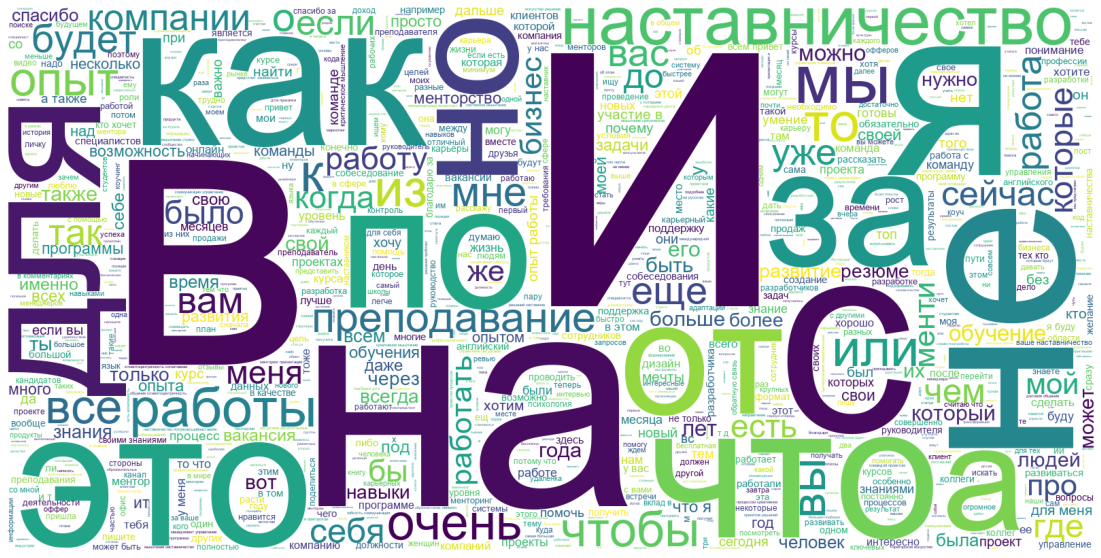

In [19]:
plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

Местоимения, предлоги, союзы и т.д помешают правильно кластеризовать тексты, поэтому зададим векторизацию при помощи `CountVectorizer` и добавим в него список стоп-слов.

Слово `это` nltk не считает стоп-словом, а мы добавим

In [20]:
stop_words = stopwords.words('russian')
stop_words.append('это')

In [21]:
# vectorizer_model = CountVectorizer(stop_words=stopwords, min_df=1, max_df=0.6)
vectorizer_model = CountVectorizer(stop_words=stop_words)

Алгоритм снижения размерности имеет стохастическое поведение. Поэтому зафиксируем его для воспроизводимости результатов

In [22]:
umap_model = UMAP(n_neighbors=15, 
                  n_components=5, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=42)

Теперь соберем модель

In [23]:
topic_model = BERTopic(language="russian",
                       top_n_words=10,
                       calculate_probabilities=True, 
                       verbose=True, 
                       vectorizer_model=vectorizer_model, 
                       min_topic_size=2, 
                       umap_model=umap_model)

In [24]:
topics, probs = topic_model.fit_transform(posts_df.post_text_cleaned)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

2023-06-30 17:45:31,653 - BERTopic - Transformed documents to Embeddings
2023-06-30 17:45:37,972 - BERTopic - Reduced dimensionality
2023-06-30 17:45:37,987 - BERTopic - Clustered reduced embeddings


In [25]:
topic_info = topic_model.get_topic_info()
topic_info.head(20)

Topic  Count                                               Name  \
0      -1     33               -1_хотим_работы_наставничество_менти   
1       0     16          0_языков_преподавание_управление_менторов   
2       1     11                            1_спасибо_очень_день_км   
3       2     10                  2_мышление_управление_знаниями_ии   
4       3     10  3_потрясающийнаставник_ваше_благодарю_наставни...   
5       4      7                4_вакансия_работа_работы_кандидатов   
6       5      6                        5_стипендии_курс_курса_моих   
7       6      5                6_резюме_преподавание_человек_учить   
8       7      5                    7_опыт_работы_знание_разработка   
9       8      4                  8_онлайн_разных_обучении_обучения   
10      9      4                      9_помогу_свои_карьерный_менти   
11     10      3               10_программистов_код_успешных_своими   
12     11      3                  11_комплаенс_антикор_года_спасибо   
13     12      3          12_блоков_платформе_удаленка_разработчика   
14     13      3                   13_плане_ощущение_приятное_очень   
15     14      3                     14_клиент_дохода_людей_текущей   
16     15      3  15_женщин_предпринимателю_программы_наставниче...   
17     16      3              16_английского_преподавание_рада_буду   
18     17      2                 17_гораздо_дизайн_туда_специалиста   
19     18      2            18_должен_соответственно_чувстве_помощь   

                                       Representation  \
0   [хотим, работы, наставничество, менти, компани...   
1   [языков, преподавание, управление, менторов, к...   
2   [спасибо, очень, день, км, думаю, большой, рез...   
3   [мышление, управление, знаниями, ии, интеллект...   
4   [потрясающийнаставник, ваше, благодарю, настав...   
5   [вакансия, работа, работы, кандидатов, менедже...   
6   [стипендии, курс, курса, моих, коучинг, мои, п...   
7   [резюме, преподавание, человек, учить, те, мом...   
8   [опыт, работы, знание, разработка, работали, д...   
9   [онлайн, разных, обучении, обучения, взрослых,...   
10  [помогу, свои, карьерный, менти, план, стороны...   
11  [программистов, код, успешных, своими, можете,...   
12  [комплаенс, антикор, года, спасибо, хорошую, п...   
13  [блоков, платформе, удаленка, разработчика, пр...   
14  [плане, ощущение, приятное, очень, нравится, к...   
15  [клиент, дохода, людей, текущей, очень, работе...   
16  [женщин, предпринимателю, программы, наставнич...   
17  [английского, преподавание, рада, буду, аналит...   
18  [гораздо, дизайн, туда, специалиста, попасть, ...   
19  [должен, соответственно, чувстве, помощь, колл...   

                                  Representative_Docs  
0   [навел меня сегодня один разговор на размышлен...  
1   [всем привет меня зовут екатерина и я бы очень...  
2   [ищу свое место под солнцем вот уже который ме...  
3   [самая большая подборка для прокачки сохрани ч...  
4   [отзывы с благодарностью благодарю за ваше нас...  
5   [ищем менеджера старшего менеджера металлургия...  
6   [я учился в высшей школе экономики факультет п...  
7   [мне не приходилось работать в школе но у меня...  
8   [всем доброго дня ищу разработчика проект прое...  
9   [рада поделиться тем что я завершила программу...  
10  [друзья в нашей индустрии рекрутинга нет ничег...  
11  [года в сегодня ровно года как я ушл в индустр...  
12  [спасибо за год совместной работы спасибо за н...  
13  [набираем разработчиков можно удаленно с нас н...  
14  [преподавание меня вдохновляет и прививает люб...  
15  [у меня была мечта найти свою компанию где я с...  
16  [мы гордимся тем что являемся частью программы...  
17  [вашему вниманию бесплатные курсы по преподава...  
18  [из новостей и своего окружения я читаю и слыш...  
19  [ищем дерзкого и задорного младшего деврела по...

Получили список тем. под -1 скрываются темы, кластеризовать которые не удалось.

Вместе с `-1` алгоритм нашел 15 тем, но мы выделяем из них 10

Можем посмотреть примеры текстов без выделенной темы

In [26]:
topic_info['Representative_Docs'][0]

['навел меня сегодня один разговор на размышления почему мне нравится моя профессия что меня драйвит и почему я этим занимаюсь дизайн одна из тех сфер где можешь на протяжение очень долгого времени пробовать себя в новых направлениях сегодня ты работаешь с айдентикой завтра работаешь над вебом послезавтра сидишь и вникаешь в новый сервис и улучшаешь его также пробуешь постоянно новые скиллы работа с типографикой иллюстрации ретушь и коллажи работа с интерфейсами и т д и т д есть возможность пробовать себя в новых ролях сначала как все начинаешь с интерна или джуниора а дальше уже двигаешься как твоей душе угодно вертикально сеньор арт дир дизайн хед или горизонтально менторство преподавание работа ин хауз фриланс или продакшн ну и каждый раз вникаешь в новые сферы в агентствах я например работала с алкогольными и автомобильными брендами потом поработала на урбанистических проектах а потом дальше понеслось а сейчас вот вообще ненадолго свернула в совершенно другую сторону и помогаю дела

Список топ 10 слов получаем из колонки `Representation`. Например, topic_0 это 

In [27]:
topic_info['Representative_Docs'][1]

['всем привет меня зовут екатерина и я бы очень хотела познакомиться с вами и рассказать о себе подробнее я основатель школы китайского языка преподаватель и переводчик китайского и полиглот преподаю китайским язык с нуля для среднего и продвинутого уровней также провожу корпоративное обучение китайскому языку в международных компаниях и открыта к новым проектам я жила и училась в китае нанкинский университет закончила мгпу в москве сейчас я развиваю свою школу иностранных языков основала первый клуб китаистов регулярно запускаю проекты и курсы связанные с обучением иностранных языков и организую оффлайн встречи с моими учениками китаистами мои языковые проекты это всегда новинки в языковой сфере и очень необычные форматы в моей школе работают только топовые носители переводчик джеки чана например билингвы и проф преподаватели китайцы также я работаю с людьми кто хочет научиться монетизировать свои знания с иностранных языков провожу наставничество по преподаванию и по развитию личного

Принадлежность текста к соответствующему кластеру можно посмотреть в атрибуте `topics_`

In [28]:
topic_model.topics_[:5]

[8, 1, 2, -1, 15]

Визуализируем результаты. карта интерактивная

In [29]:
topic_model.visualize_topics()

Алгоритм нашел 5 кластеров тем про наставничество, которые нравятся целевой аудитории.

Можно посмотреть вероятность отнесения поста к той или иной теме. К примеру, у нас в датасете есть несколько постов с отзывами

In [30]:
posts_df.iloc[30]['post_text']

'Darya S. #Отзывы с благодарностью Благодарю за Ваше наставничество #Потрясающий_наставник '

In [31]:
topic_model.visualize_distribution(probs[30], min_probability=0.01)

В данном случае алгоритм не ошибся и явно пометил нужный пост в соответствующую тему =)

Построим также карту иерархичской кластеризации

In [32]:
topic_model.visualize_hierarchy(top_n_topics=20, height=1000)

Теперь проверим те тексты, которые нравятся ЦА

In [35]:
topic_model = BERTopic(language="russian",
                       top_n_words=10,
                       calculate_probabilities=True, 
                       verbose=True, 
                       vectorizer_model=vectorizer_model, 
                       min_topic_size=3, 
                       umap_model=umap_model)

In [36]:
topics, probs = topic_model.fit_transform(user_posts_array_cleaned)

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

2023-06-30 17:45:43,188 - BERTopic - Transformed documents to Embeddings
2023-06-30 17:45:46,200 - BERTopic - Reduced dimensionality
2023-06-30 17:45:46,364 - BERTopic - Clustered reduced embeddings


In [37]:
topic_info = topic_model.get_topic_info()
topic_info.head(20)

Topic  Count                                           Name  \
0      -1    214                        -1_очень_всем_день_буду   
1       0     40                  0_ура_согласны_шпаргалка_none   
2       1     32      1_сообщаю_начинаю_удовольствием_должности   
3       2     25                     2_москва_банк_услуг_россии   
4       3     25          3_готов_разработчика_разработчик_всем   
5       4     23       4_тестовое_тестовые_тестирование_задание   
6       5     18  5_сотрудников_кандидат_талантливых_кандидатов   
7       6     17           6_треке_санкт_петербурга_мероприятия   
8       7     15                 7_война_войну_россии_беларусов   
9       8     14        8_приложение_чистом_интерфейс_элементов   
10      9     14            9_английского_тест_английский_языка   
11     10     14  10_данных_разрабатывать_решений_разработчиков   
12     11     13       11_отзывы_добавил_благодарностью_спасибо   
13     12     12           12_собеседование_алго_ходил_компании   
14     13     12            13_вакансии_канал_уровней_телеграмм   
15     14     11                   14_проекты_компании_вс_месяц   
16     15     11           15_навык_проверку_следующим_пройдите   
17     16     10                    16_дню_гофер_добавляется_ад   
18     17     10             17_язык_бесят_которые_программисты   
19     18     10       18_собеседования_вопросы_интервью_бывают   

                                       Representation  \
0   [очень, всем, день, буду, работы, привет, вс, ...   
1   [ура, согласны, шпаргалка, none, яковлев, аксе...   
2   [сообщаю, начинаю, удовольствием, должности, н...   
3   [москва, банк, услуг, россии, российских, комп...   
4   [готов, разработчика, разработчик, всем, разра...   
5   [тестовое, тестовые, тестирование, задание, ух...   
6   [сотрудников, кандидат, талантливых, кандидато...   
7   [треке, санкт, петербурга, мероприятия, победи...   
8   [война, войну, россии, беларусов, враг, русски...   
9   [приложение, чистом, интерфейс, элементов, зад...   
10  [английского, тест, английский, языка, слов, г...   
11  [данных, разрабатывать, решений, разработчиков...   
12  [отзывы, добавил, благодарностью, спасибо, бан...   
13  [собеседование, алго, ходил, компании, итоге, ...   
14  [вакансии, канал, уровней, телеграмм, исправит...   
15  [проекты, компании, вс, месяц, работу, свои, о...   
16  [навык, проверку, следующим, пройдите, значок,...   
17  [дню, гофер, добавляется, ад, праграмста, што,...   
18  [язык, бесят, которые, программисты, подойдет,...   
19  [собеседования, вопросы, интервью, бывают, соб...   

                                  Representative_Docs  
0   [привет всем меня зовут никита мне лет и я из ...  
1   [согласны, каршеринг маилру сбербанк сбер, шпа...  
2   [с удовольствием сообщаю что я начинаю работу ...  
3   [читаю новости про уход из россии и общаюсь с ...  
4   [привет мир ищу работу разработчика пишу этот ...  
5   [а вот и очередное тестовое задание от очередн...  
6   [ошибки мышления при поиске работы сверх обобщ...  
7   [работа в газпромбанке это еще и продвинутая к...  
8   [а вот и мой первый пост с рубрикой непопулярн...  
9   [не люблю я тестовые задания и вот почему вчер...  
10  [как выучить английский самостоятельно без зат...  
11  [компания мтт рассматривает в штат разработчик...  
12  [отзывы с благодарностью спасибо что подаете н...  
13  [в поиске хорошей работы про хорошую для меня ...  
14  [вопросы для подготовки к собеседования для вс...  
15  [всем привет хочу рассказать про свой опыт раб...  
16  [я только что получил а значок за навык кто хо...  
17  [кажется можно накидывать к текущему грейду ве...  
18  [привет всем кто как и я осваивает разработку ...  
19  [собеседование на и как к нему подготовиться к...

In [38]:
topic_info['Representation'].values

array([list(['очень', 'всем', 'день', 'буду', 'работы', 'привет', 'вс', 'опыт', 'работать', 'лет']),
       list(['ура', 'согласны', 'шпаргалка', 'none', 'яковлев', 'аксенов', 'жизньпрограммиста', 'зжено', 'звуком', 'выражениям']),
       list(['сообщаю', 'начинаю', 'удовольствием', 'должности', 'новой', 'работу', 'компании', 'команде', 'аналитики', 'рекрутер']),
       list(['москва', 'банк', 'услуг', 'россии', 'российских', 'компании', 'рынке', 'специалистов', 'инвесторов', 'руб']),
       list(['готов', 'разработчика', 'разработчик', 'всем', 'разработки', 'ищу', 'работы', 'буду', 'рассмотреть', 'привет']),
       list(['тестовое', 'тестовые', 'тестирование', 'задание', 'ухуели', 'например', 'тестирования', 'сделайте', 'тестовых', 'ссылка']),
       list(['сотрудников', 'кандидат', 'талантливых', 'кандидатов', 'кандидаты', 'нужно', 'смысла', 'мотивации', 'мотивирующим', 'предоставление']),
       list(['треке', 'санкт', 'петербурга', 'мероприятия', 'победителям', 'газпромбанке', 'про

In [39]:
topic_info['Representative_Docs'].iloc[10]

['как выучить английский самостоятельно без затратчтобы выучить английский язык самостоятельно нужно придерживаться следующих правил обязательный специальный график ежедневного касания с языком как минимум минут в день можно больше но повторюсь регулярно без пауз это очень важно как прием лекарств назначенных врачем лучшим временем для изучения языка считается утро сразу после просыпания и вечер перед сном комбинировать виды работы чтение говорение письмо аудирование слушание всего по от общего времени материал должен быть на стене в тетради в телефоне в компьютере в машине и в ухе наушнике с первого дня вы уже учите песню смотрите минут фильма учите транскрипцию и делаете один тест по грамматике это все в первый день изучения пятиминутное касание к каждому виду работы сегодня идет вместо минут завтра послезавтра если просто то не откладывай на завтра то что можно сделать сегодня из словаря каждый день учим и проговариваем пять новых слов они в пердложениях на стене в телефоне скрин пр

In [40]:
user_posts_array_cleaned[np.array(topic_model.topics_) == 15]

array(['я только что получил а значок за навык кто хочет быть следующим пройдите тест на проверку навыков',
       'я только что получил а значок за навык кто хочет быть следующим пройдите тест на проверку навыков',
       'я только что получил а значок за навык кто хочет быть следующим пройдите тест на проверку навыков',
       'я только что получил а значок за навык кто хочет быть следующим пройдите тест на проверку навыков',
       'я только что получил а значок за навык кто хочет быть следующим пройдите тест на проверку навыков',
       'я только что получил а значок за навык кто хочет быть следующим пройдите тест на проверку навыков',
       'защитил свой первый диплом в если кто то в условиях карантина вс же ищет джуна на врстку вы знаете что делать а я пока перехожу к курсу по верстальщик ищуработу',
       'я только что получил а значок за навык разработка клиентской стороны кто хочет быть следующим пройдите тест на проверку навыков',
       'я только что получил а значок за на